### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Directory

In [2]:
##!!IMPORTANT
##your outputdir should be accessible by both the notebooks
outputdir='/content/drive/MyDrive/'
inputpath='/content/drive/MyDrive/train-withclasses.csv'

### Dependencies

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#For decision tree scikit learn
from sklearn.ensemble import RandomForestClassifier as forest

#for Neural net
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.preprocessing import LabelEncoder as le
from scipy.special import softmax
from sklearn.model_selection import StratifiedKFold as SKF






## Helper Function

In [4]:
#Accuracy function defined for later use
def accuracy(ytest,ypred):
  return sum(ypred==ytest)/len(ytest)

### Reading File

In [5]:
dataastro=pd.read_csv(inputpath)


In [6]:
dataastro.head()

,Unnamed: 0,u-g,g-r,r-i,i-z,ecc,m4_u,m4_g,m4_r,m4_i,m4_z,petroR50_u,petroR50_r,petroR50_z,petroR90_u,petroR90_r,petroR90_z,class
0,0,1.45293,0.63368,0.40208,0.26573,0.390929,2.110849,2.156260,2.143514,2.234040,2.247642,1.666188,1.683902,1.375343,3.026231,3.700802,3.074833,merger
1,1,1.56972,0.63443,0.34753,0.15197,0.915341,2.352859,2.433820,2.471458,2.509777,2.517170,9.588296,8.813774,7.456224,21.645460,22.488610,20.188500,spiral
2,2,1.46475,0.55405,0.36165,0.19781,0.540382,1.827454,2.003867,2.121698,2.175802,2.234748,4.358751,4.622508,4.221008,8.496148,9.563267,9.114655,spiral
3,3,1.95080,0.88949,0.40561,0.32002,0.895771,2.444309,2.463624,2.439433,2.424131,2.404567,7.495163,5.190655,4.992559,21.047320,15.879200,14.782440,elliptical
4,4,2.03924,1.03214,0.42926,0.35035,0.906710,2.338428,2.368874,2.358188,2.397348,2.364135,2.464064,2.392333,2.247000,8.777987,7.884397,7.387922,elliptical


In [8]:
dataastro.info()
#no null values as we can see

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  546 non-null    int64  
 1   u-g         546 non-null    float64
 2   g-r         546 non-null    float64
 3   r-i         546 non-null    float64
 4   i-z         546 non-null    float64
 5   ecc         546 non-null    float64
 6   m4_u        546 non-null    float64
 7   m4_g        546 non-null    float64
 8   m4_r        546 non-null    float64
 9   m4_i        546 non-null    float64
 10  m4_z        546 non-null    float64
 11  petroR50_u  546 non-null    float64
 12  petroR50_r  546 non-null    float64
 13  petroR50_z  546 non-null    float64
 14  petroR90_u  546 non-null    float64
 15  petroR90_r  546 non-null    float64
 16  petroR90_z  546 non-null    float64
 17  class       546 non-null    object 
dtypes: float64(16), int64(1), object(1)
memory usage: 76.9+ KB


In [9]:
dataastro.describe()
#the difference between max and 75 perc indicates possibility of outliers

,Unnamed: 0,u-g,g-r,r-i,i-z,ecc,m4_u,m4_g,m4_r,m4_i,m4_z,petroR50_u,petroR50_r,petroR50_z,petroR90_u,petroR90_r,petroR90_z
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,272.500000,1.621031,0.738487,0.386943,0.262595,0.706210,-16.064267,2.322630,-15.950923,-34.253038,-15.933738,-31.401765,4.785159,-32.370787,-23.948400,12.526925,-25.316320
std,157.760895,0.444366,0.371408,0.093002,0.385598,0.172141,428.015446,0.161151,428.018997,604.755608,428.019737,604.939673,3.210711,604.877694,605.452545,7.893868,605.342460
min,0.000000,0.023010,-4.708600,-0.630590,-6.954270,0.226894,-9999.000000,0.576167,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.617535,-9999.000000,-9999.000000,1.031904,-9999.000000
25%,136.250000,1.333158,0.613480,0.352258,0.228042,0.581773,2.116728,2.225103,2.300352,2.321738,2.326324,2.841682,2.962981,2.579287,7.207228,8.202056,7.193998
50%,272.500000,1.685430,0.783180,0.397610,0.289395,0.739144,2.265292,2.351189,2.381582,2.394982,2.392273,4.415234,3.964163,3.499351,10.654170,10.583790,9.485076
75%,408.750000,1.908080,0.894947,0.429560,0.324175,0.846769,2.390433,2.423310,2.439580,2.454056,2.454534,6.264471,5.509680,4.978661,15.189455,14.445925,13.508085
max,545.000000,7.387130,1.539170,0.729730,4.879330,0.996409,26.009380,2.690040,2.737767,2.728628,2.730472,30.995970,36.376200,39.350240,112.493900,83.937670,95.710950


### Scatter Plots of all columns

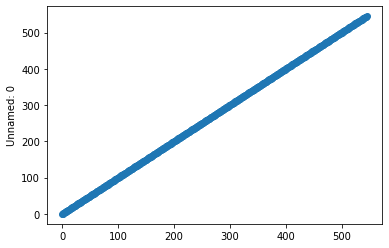

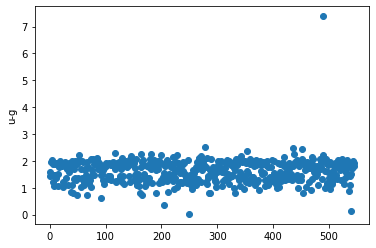

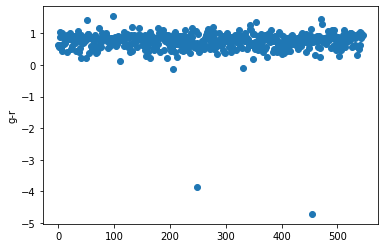

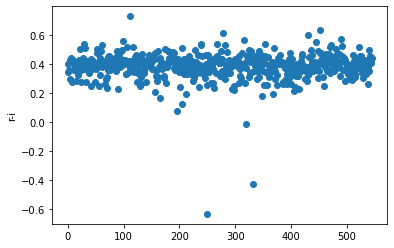

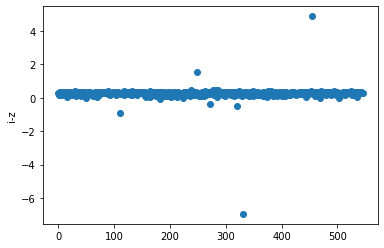

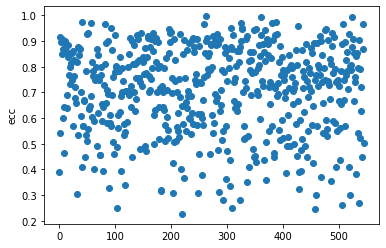

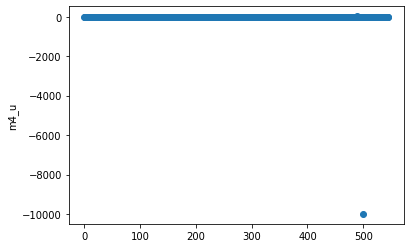

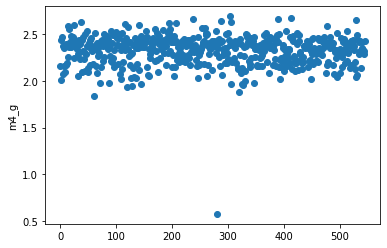

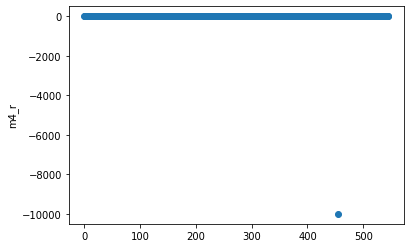

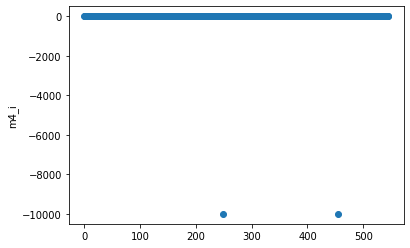

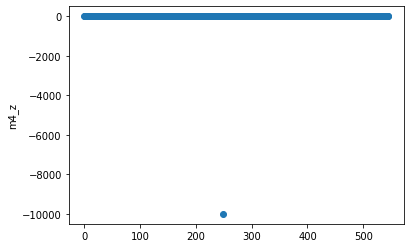

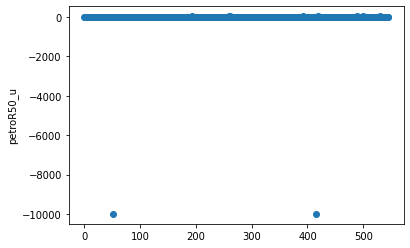

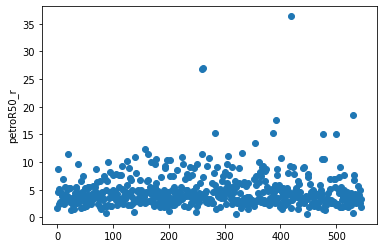

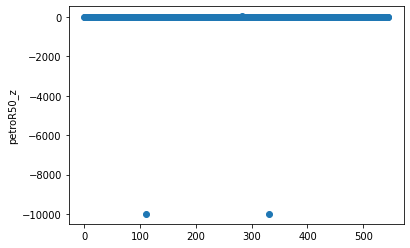

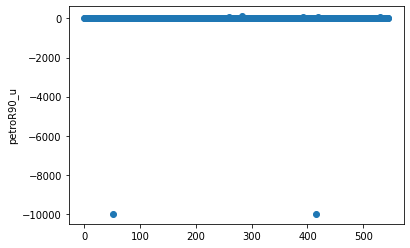

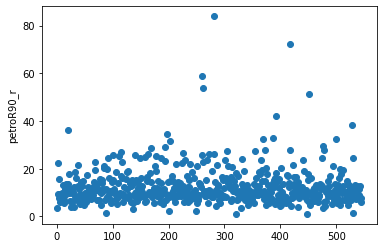

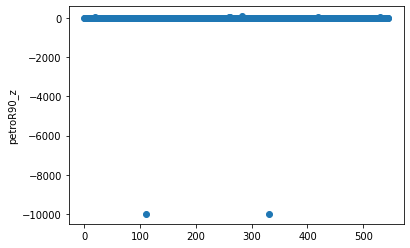

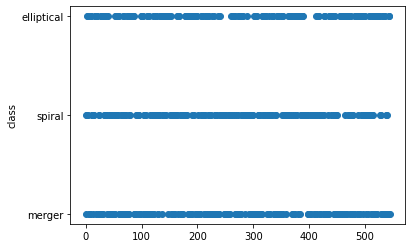

In [10]:
for i in dataastro.columns:
  plt.scatter(dataastro['Unnamed: 0'],dataastro[i])
  plt.ylabel(i)
  plt.show()
#as we see there are a lot Outliers visible during plotting

In [11]:
#No of datapoints in each class
dataastro.groupby(['class'])['class'].count()

class
elliptical    177
merger        180
spiral        189
Name: class, dtype: int64

## Removing Outliers

In [12]:
dataset=dataastro


In [13]:
for i in range(len(dataset.columns)-1):
  per75=dataastro.iloc[:,i].quantile(0.75)
  per25=dataastro.iloc[:,i].quantile(0.25)
  factor=per75-per25
  dataset=dataset.drop(dataset[np.logical_or(dataset.iloc[:,i] < (per25 - 1.5 * factor),dataset.iloc[:,i] > (per75 + 1.5 * factor))].index)

In [14]:
#No of datapoints in each class after filtering
dataset.groupby(['class'])['class'].count()

class
elliptical    158
merger        126
spiral        124
Name: class, dtype: int64

In [15]:
dataset=dataset.drop('Unnamed: 0',axis=1)
dataset=dataset.reset_index()
dataset=dataset.drop('index',axis=1)

### Separating features and labels

In [30]:

datalabel=dataset['class']
datafeat=dataset.drop(['class'],axis=1)
#for dummy testuse later
datafeat.to_csv(outputdir+'dummytest.csv')
datafeat

,u-g,g-r,r-i,i-z,ecc,m4_u,m4_g,m4_r,m4_i,m4_z,petroR50_u,petroR50_r,petroR50_z,petroR90_u,petroR90_r,petroR90_z
0,1.45293,0.63368,0.40208,0.26573,0.390929,2.110849,2.156260,2.143514,2.234040,2.247642,1.666188,1.683902,1.375343,3.026231,3.700802,3.074833
1,1.56972,0.63443,0.34753,0.15197,0.915341,2.352859,2.433820,2.471458,2.509777,2.517170,9.588296,8.813774,7.456224,21.645460,22.488610,20.188500
2,1.46475,0.55405,0.36165,0.19781,0.540382,1.827454,2.003867,2.121698,2.175802,2.234748,4.358751,4.622508,4.221008,8.496148,9.563267,9.114655
3,1.95080,0.88949,0.40561,0.32002,0.895771,2.444309,2.463624,2.439433,2.424131,2.404567,7.495163,5.190655,4.992559,21.047320,15.879200,14.782440
4,2.03924,1.03214,0.42926,0.35035,0.906710,2.338428,2.368874,2.358188,2.397348,2.364135,2.464064,2.392333,2.247000,8.777987,7.884397,7.387922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,1.74008,1.03091,0.44769,0.29487,0.722295,2.467585,2.354569,2.375811,2.391762,2.371070,4.524202,3.242836,2.468044,13.984660,11.671590,9.855418
404,1.74526,0.84755,0.45648,0.33945,0.448275,2.144437,2.325891,2.359190,2.359857,2.425203,5.893588,4.987450,4.776126,14.274740,12.674490,13.718050
405,1.98799,0.99956,0.42696,0.36499,0.867389,2.380038,2.314563,2.373675,2.359678,2.355044,2.621158,2.525896,2.594247,5.187862,7.827496,7.959360
406,1.93320,0.90821,0.40950,0.30650,0.966950,2.201478,2.286988,2.314348,2.324615,2.315512,2.066934,1.955862,1.841433,6.857877,6.108925,5.932195


## SKlearn Models for getting a benchmark

In [17]:
xtrain,xtest,ytrain,ytest=train_test_split(datafeat,datalabel,test_size=0.2,random_state=11)

In [18]:
classifier=forest()
classifier.fit(xtrain,ytrain)
ypred=classifier.predict(xtest)

In [19]:
accuracy(ytest,ypred)

0.8658536585365854

## Neural Net Model

using stratified k fold

In [20]:
kfold=SKF(n_splits=5,shuffle=True,random_state=11)

### Preparing Dataset for further use

In [21]:
le1=le()
dataf=torch.tensor(np.array(datafeat),dtype=torch.float32)
#Encoding the labels and saving it
labelf=torch.tensor(le1.fit_transform(datalabel))
np.save(outputdir+'encodings.npy',le1.classes_)
num_features=dataf.shape[1]

## Model

In [22]:

model=nn.Sequential(nn.BatchNorm1d(num_features),
    nn.Linear(num_features,8),
    nn.ReLU(),
    nn.BatchNorm1d(8),
    nn.Linear(8,3)
    
)

  

Defining OPtimizer and LossFn

In [23]:
optimizer=Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

### Train Function

In [24]:
#IT saves the 5 models run on different folds
def train(model,optimizer,datafeat,datalabel):
  #original dict saved for reinitializing
  torch.save(model.state_dict(), outputdir+'cache.pt')
  #running across various folds
  for i,(train_idx,test_idx) in enumerate(kfold.split(datafeat,datalabel)):
    
    model.load_state_dict(torch.load(outputdir+'cache.pt'))
    #getting the training data and validation data from various folds
    xtrain,xtest=datafeat.loc[train_idx],datafeat.loc[test_idx]
    ytrain,ytest=datalabel[train_idx],datalabel[test_idx]
    xtrain=torch.tensor(np.array(xtrain),dtype=torch.float32)
    xtest=torch.tensor(np.array(xtest),dtype=torch.float32)
   
    #encoding labels
    ytrain=torch.tensor(le1.fit_transform(ytrain))
    ytest=torch.tensor(le1.fit_transform(ytest))
    g=0
    #training model
    for j in range(2000):
       model.train()
       ypred=model(xtrain)
       loss=loss_fn(ypred,ytrain)
       loss.backward()
       optimizer.step()
       optimizer.zero_grad()
    
       with torch.no_grad():
            model.eval()
            ypred2=model(xtest)
            valloss=loss_fn(ypred2,ytest)
            b=accuracy(softmax(ypred2).argmax(axis=1),ytest)
            if j==0:
              print(b*100)
            if j==0 or g<b:
              g=b
              torch.save(model,outputdir+'model{}.pth'.format(i))
              lossbest=loss
    print('fold:{}'.format(i))
    print('loss-{}'.format(lossbest))
    print('accuracy-{}'.format(g*100))

              
              

  


In [25]:
train(model,optimizer,datafeat,datalabel)

tensor(29.2683)
fold:0
loss-0.2448049634695053
accuracy-86.58536529541016
tensor(30.4878)
fold:1
loss-0.16676999628543854
accuracy-87.80487823486328
tensor(29.2683)
fold:2
loss-0.32928407192230225
accuracy-90.243896484375
tensor(33.3333)
fold:3
loss-0.1259361207485199
accuracy-91.35802459716797
tensor(30.8642)
fold:4
loss-0.11026789247989655
accuracy-86.41975402832031


### Final Model

In [26]:
#combining all models to form a final model
class final_model(nn.Module):
  def __init__(self):
        super().__init__()
        self.model1=torch.load(outputdir+'model0.pth')
        self.model1.eval()
        self.model2=torch.load(outputdir+'model1.pth')
        self.model2.eval()
        self.model3=torch.load(outputdir+'model2.pth')
        self.model3.eval()
        self.model4=torch.load(outputdir+'model3.pth')
        self.model4.eval()
        self.model5=torch.load(outputdir+'model4.pth')
        self.model5.eval()
        self
  def forward(self,X):
    with torch.no_grad():
      output=(self.model1(X)+self.model2(X)+self.model3(X)+self.model4(X)+self.model5(X))/5
      output=softmax(output).argmax(axis=1)
      k=np.array(le1.inverse_transform(output))

      return output,k



In [27]:
modelf=final_model()
torch.save(modelf,outputdir+'model.pth')

ypred,ypredlabel=modelf(dataf)

In [28]:
print(accuracy(ypred,labelf)*100)

tensor(93.6275)


In [29]:
print(accuracy(np.array(ypredlabel),np.array(datalabel))*100)

93.62745098039215


## Comment-
## 1-We Used Neural Net as generally astronomical data is huge so for a bigger dataset its performance will increase more as compared to other models 
##  2-We found that the  dataset had a lot of outliers removing which increased both our accuracy and its consistancy
##   3- Our Model Outperforms Random Forest which we aimed for initially
